# **Klasifikasi Tingkat Kematangan Buah Pisang Menggunakan Convolutional Neural Network (CNN)**

## **Objective:**   
mengembangkan model deep learning berbasis Convolutional Neural Network (CNN) guna mengklasifikasikan tingkat kematangan buah pisang ke dalam empat kategori: *unripe*, *ripe*, *overripe*, dan *rotten*.

Keterangan:
1. Unripe → Mentah
2. Ripe → Matang
3. Overripe → Terlalu Matang
4. Rotten → Busuk

## **Sumber Dataset**
https://www.kaggle.com/datasets/atrithakar/banana-classification

## **Import Libraries**

In [1]:
# Import modules & Set SEED
import os
import gdown
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## **Data Loading**

In [2]:
# Download dari Google Drive
file_id = "1oL0-ehm1l6Vmgv3IXZGQf44OJ0D-tS6C"
output_zip = "banana_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

# Ekstrak zip ke folder
extract_dir = "banana_dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Dataset berhasil diunduh dan diekstrak.")

Downloading...
From (original): https://drive.google.com/uc?id=1oL0-ehm1l6Vmgv3IXZGQf44OJ0D-tS6C
From (redirected): https://drive.google.com/uc?id=1oL0-ehm1l6Vmgv3IXZGQf44OJ0D-tS6C&confirm=t&uuid=5aa7de67-866c-4287-935b-4785a9e38beb
To: /content/banana_dataset.zip
100%|██████████| 228M/228M [00:04<00:00, 49.3MB/s]


✅ Dataset berhasil diunduh dan diekstrak.


### **Plot gambar sampel untuk semua kelas**

Kelas ditemukan: ['overripe', 'ripe', 'rotten', 'unripe']


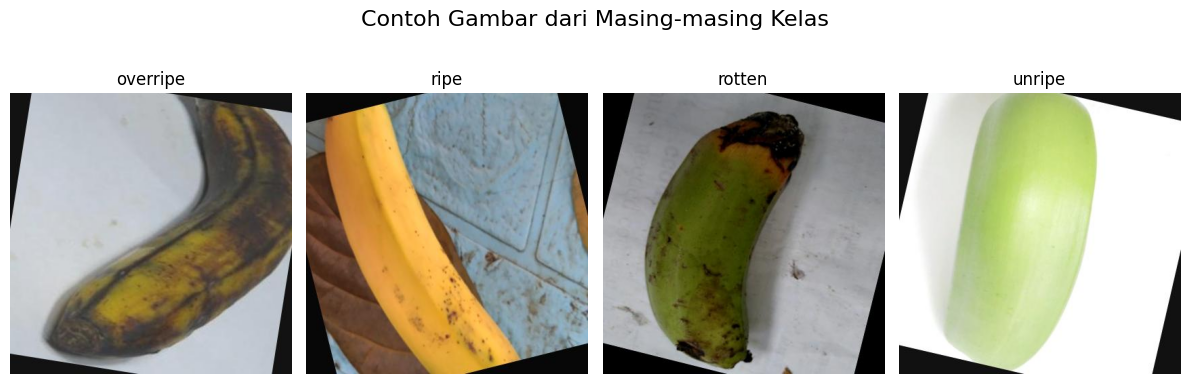

In [3]:
# Path ke folder dataset setelah ekstraksi
dataset_path = "banana_dataset/banana_dataset"

# Ambil nama kelas
classes = sorted(os.listdir(dataset_path))
print(f"Kelas ditemukan: {classes}")

# Tampilkan satu gambar acak dari setiap kelas
plt.figure(figsize=(12, 8))
for idx, label in enumerate(classes):
    class_folder = os.path.join(dataset_path, label)
    img_files = os.listdir(class_folder)
    if img_files:
        img_path = os.path.join(class_folder, random.choice(img_files))
        img = Image.open(img_path)
        plt.subplot(2, len(classes), idx+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

plt.suptitle("Contoh Gambar dari Masing-masing Kelas", fontsize=16)
plt.tight_layout()
plt.show()

### **Plot distribusi gambar di seluruh kelas**

<ipython-input-4-ef74b5c72e96>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


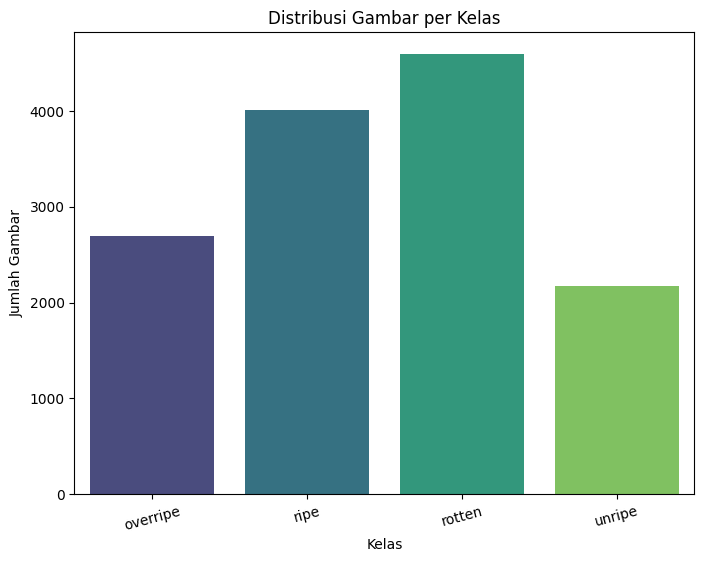

In [4]:
# Hitung jumlah gambar di setiap kelas
class_counts = {
    label: len(os.listdir(os.path.join(dataset_path, label)))
    for label in classes
}

# Visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=15)
plt.show()

## **Data Splitting : Training, Validation, and Testing**

In [5]:
dataset_path = "banana_dataset/banana_dataset"
classes = sorted(os.listdir(dataset_path))

image_paths = []  # Menyimpan path setiap gambar
image_labels = []  # Menyimpan label setiap gambar

# Loop melalui setiap kelas untuk mengambil gambar
for label in classes:
    class_folder = os.path.join(dataset_path, label)
    img_files = os.listdir(class_folder)

    for img_file in img_files:
        image_paths.append(os.path.join(class_folder, img_file))
        image_labels.append(label)  # Label sesuai nama folder

# Cetak jumlah total gambar yang ditemukan
print(f"Total gambar ditemukan: {len(image_paths)}")

Total gambar ditemukan: 13478


In [6]:
# Split pertama: Memisahkan data menjadi data pelatihan (train) dan data sisa (sementara disebut test)
# - test_size=0.2 artinya 20% data dijadikan test sementara, sisanya 80% untuk training
# - random_state=SEED memastikan pembagian data konsisten setiap kali dijalankan
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.2, random_state=SEED
)

# Split kedua: Memisahkan 20% data test tadi menjadi dua bagian: validasi dan test akhir (testing)
# - test_size=0.5 artinya 50% dari data test akan menjadi test akhir (testing), dan sisanya untuk validasi
# - Karena sebelumnya hanya 20% dari data awal, maka 50% dari 20% = 10% jadi testing dan 10% jadi validasi
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=SEED
)

## **Data Preparation using `tf.data.Dataset`**

Alih-alih menggunakan `ImageDataGenerator`, proyek ini menggunakan API `tf.data.Dataset` dari TensorFlow yang memberikan fleksibilitas dan efisiensi lebih tinggi dalam menangani dan melakukan *data preprocessing*. Pendekatan ini memungkinkan kontrol yang lebih besar terhadap proses pemuatan data, transformasi, pengelompokan (*batching*), hingga optimisasi performa.

In [7]:
# Parameter
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Buat mapping label string ke angka
classes = sorted(set(train_labels + val_labels + test_labels))
label_to_index = {label: idx for idx, label in enumerate(classes)}

# Ubah label string ke angka
train_labels_idx = [label_to_index[label] for label in train_labels]
val_labels_idx = [label_to_index[label] for label in val_labels]
test_labels_idx = [label_to_index[label] for label in test_labels]

# Konversi ke tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_idx))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_idx))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_idx))

# Fungsi preprocessing
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Terapkan ke dataset
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Cek info
print(f"Classes: {label_to_index}")
print(f"Total train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Classes: {'overripe': 0, 'ripe': 1, 'rotten': 2, 'unripe': 3}
Total train: 10782, val: 1348, test: 1348


## **Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):**

In [34]:
# Clear previous model
tf.keras.backend.clear_session()

# Inisialisasi model
model_1 = Sequential()

# 1st Convolutional layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model_1.add(Conv2D(32, (4, 4), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten & Fully Connected Layers
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))  # multi-class

# Compile model
model_1.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00002),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Summary
model_1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,287,812 (12.54 MB)

 Trainable params: 3,287,620 (12.54 MB)

 Non-trainable params: 192 (768.00 B)

In [35]:
# Callback untuk menyimpan model terbaik
checkpoint_1 = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

# Early stopping untuk menghentikan training jika tidak ada perbaikan dalam validasi loss
early_stopping_1 = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# Training model dengan dataset
history_1 = model_1.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint_1, early_stopping_1]
)

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5446 - loss: 1.2195
Epoch 1: val_loss improved from inf to 1.18570, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.5450 - loss: 1.2185 - val_accuracy: 0.5141 - val_loss: 1.1857
Epoch 2/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7999 - loss: 0.5252
Epoch 2: val_loss improved from 1.18570 to 0.38673, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.8000 - loss: 0.5250 - val_accuracy: 0.8717 - val_loss: 0.3867
Epoch 3/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8511 - loss: 0.4141
Epoch 3: val_loss improved from 0.38673 to 0.29610, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8511 - loss: 0.4140 - val_accuracy: 0.9036 - val_loss: 0.2961
Epoch 4/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8678 - loss: 0.3760
Epoch 4: val_loss improved from 0.29610 to 0.26695, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.8678 - loss: 0.3758 - val_accuracy: 0.9147 - val_loss: 0.2670
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8898 - loss: 0.3235
Epoch 5: val_loss improved from 0.26695 to 0.24331, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.8898 - loss: 0.3234 - val_accuracy: 0.9162 - val_loss: 0.2433
Epoch 6/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8999 - loss: 0.2779
Epoch 6: val_loss did not improve from 0.24331
337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.8999 - loss: 0.2779 - val_accuracy: 0.9088 - val_loss: 0.2626
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9095 - loss: 0.2573
Epoch 7: val_loss did not improve from 0.24331
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9095 - loss: 0.2573 - val_accuracy: 0.9243 - val_loss: 0.2513
Epoch 8/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9136 - loss: 0.2423
Epoch 8: val_loss did not improve from 0.24331
337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.9136 - loss: 0.2423 - val_accuracy: 0.9184 - val_loss: 0.2588
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9242 - loss: 0.2108
Epoch 9: val_loss improved from 0.2

337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.9242 - loss: 0.2108 - val_accuracy: 0.9288 - val_loss: 0.2262
Epoch 10/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9332 - loss: 0.1956
Epoch 10: val_loss did not improve from 0.22617
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9332 - loss: 0.1955 - val_accuracy: 0.9280 - val_loss: 0.2325
Epoch 11/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9313 - loss: 0.1932
Epoch 11: val_loss improved from 0.22617 to 0.21583, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.9314 - loss: 0.1931 - val_accuracy: 0.9340 - val_loss: 0.2158
Epoch 12/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9398 - loss: 0.1610
Epoch 12: val_loss did not improve from 0.21583
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.9398 - loss: 0.1610 - val_accuracy: 0.9295 - val_loss: 0.2292
Epoch 13/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9402 - loss: 0.1646
Epoch 13: val_loss did not improve from 0.21583
337/337 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.9403 - loss: 0.1646 - val_accuracy: 0.9295 - val_loss: 0.2584
Epoch 14/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9477 - loss: 0.1502
Epoch 14: val_loss did not improve from 0.21583
337/337 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.9478 - loss: 0.1501 - val_accuracy: 0.9266 - val_loss: 0.2671
Epoch 15/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9534 - loss: 0.1294
Epoch 15: val_loss improved 

337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9534 - loss: 0.1294 - val_accuracy: 0.9340 - val_loss: 0.2122
Epoch 16/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9590 - loss: 0.1189
Epoch 16: val_loss did not improve from 0.21215
337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.9590 - loss: 0.1189 - val_accuracy: 0.9318 - val_loss: 0.2316
Epoch 17/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9628 - loss: 0.1133
Epoch 17: val_loss did not improve from 0.21215
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9628 - loss: 0.1133 - val_accuracy: 0.9206 - val_loss: 0.2728
Epoch 18/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9679 - loss: 0.0989
Epoch 18: val_loss did not improve from 0.21215
337/337 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.9679 - loss: 0.0989 - val_accuracy: 0.9332 - val_loss: 0.2578
Epoch 19/50
336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9664 - loss: 0.0940
Epoch 19: val_loss did not i

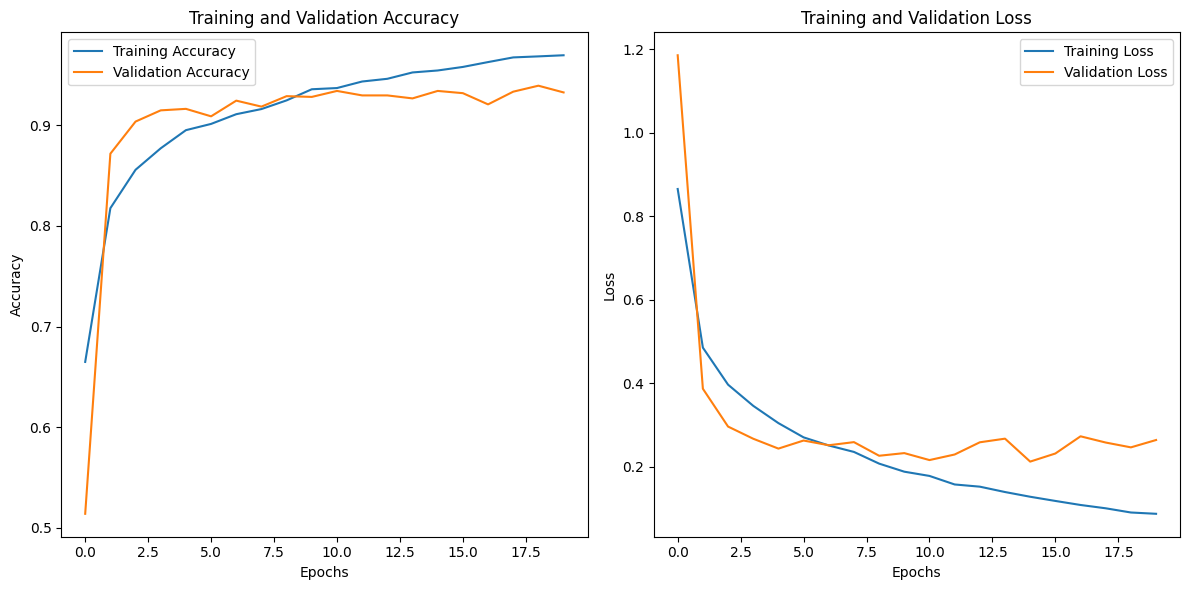

In [36]:
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.9392
F1-score (Macro Average): 0.9383
F1-score (Micro Average): 0.9392
F1-score (Weighted Average): 0.9392


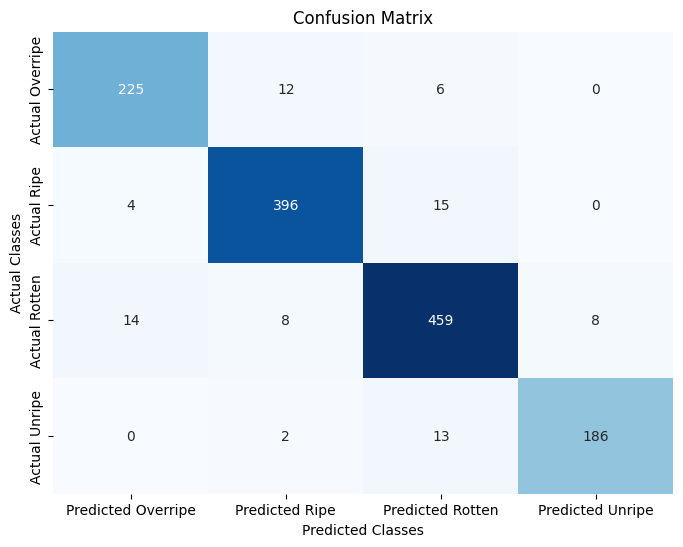


Classification Report:
              precision    recall  f1-score   support

    Overripe     0.9259    0.9259    0.9259       243
        Ripe     0.9474    0.9542    0.9508       415
      Rotten     0.9310    0.9387    0.9348       489
      Unripe     0.9588    0.9254    0.9418       201

    accuracy                         0.9392      1348
   macro avg     0.9408    0.9360    0.9383      1348
weighted avg     0.9393    0.9392    0.9392      1348



In [37]:
# Menghitung prediksi untuk data testing
preds_1 = model_1.predict(test_ds, verbose=0)

# Prediksi kelas dengan probabilitas tertinggi
predicted_classes_1 = tf.argmax(preds_1, axis=-1).numpy()

# Menghitung akurasi
accuracy_1 = accuracy_score(test_labels_idx, predicted_classes_1)
print(f"Accuracy: {accuracy_1:.4f}")

# Menghitung F1-score untuk setiap kelas dan rata-rata (macro, micro, weighted)
f1_macro_1 = f1_score(test_labels_idx, predicted_classes_1, average='macro')
f1_micro_1 = f1_score(test_labels_idx, predicted_classes_1, average='micro')
f1_weighted_1 = f1_score(test_labels_idx, predicted_classes_1, average='weighted')

print(f"F1-score (Macro Average): {f1_macro_1:.4f}")
print(f"F1-score (Micro Average): {f1_micro_1:.4f}")
print(f"F1-score (Weighted Average): {f1_weighted_1:.4f}")

# Confusion Matrix
cm_1 = confusion_matrix(test_labels_idx, predicted_classes_1, labels=[0, 1, 2, 3])
cm_df_1 = pd.DataFrame(cm_1, index=["Actual Overripe", "Actual Ripe", "Actual Rotten", "Actual Unripe"],
                     columns=["Predicted Overripe", "Predicted Ripe", "Predicted Rotten", "Predicted Unripe"])

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels_idx, predicted_classes_1, target_names=['Overripe', 'Ripe', 'Rotten', 'Unripe'], digits=4))

## **Model Exp 2 - CNN Architecture Using 64 Neurons in Conv Layer:**


In [38]:
# Clear previous model
tf.keras.backend.clear_session()

# Inisialisasi model
model_2 = Sequential()

# 1st Convolutional layer
model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))  # Filter 64
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model_2.add(Conv2D(64, (4, 4), padding='same', activation='relu'))  # Filter 64
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model_2.add(Conv2D(64, (7, 7), padding='same', activation='relu'))  # Filter 64
model_2.add(BatchNormalization())
model_2.add(MaxPool2D((2, 2)))

# Flatten & Fully Connected Layers
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Dense(64, activation='relu'))  # Dense Layer dengan 64 neuron
model_2.add(Dropout(0.3))
model_2.add(Dense(4, activation='softmax'))  # multi-class

# Compile model dengan SGD optimizer
model_2.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Summary
model_2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,700,100 (25.56 MB)

 Trainable params: 6,699,716 (25.56 MB)

 Non-trainable params: 384 (1.50 KB)

In [39]:
# Callback untuk menyimpan model terbaik
checkpoint_2 = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

# Early stopping untuk menghentikan training jika tidak ada perbaikan dalam validasi loss
early_stopping_2 = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# Training model dengan dataset
history_2 = model_2.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint_2, early_stopping_2]
)

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5267 - loss: 1.2233
Epoch 1: val_loss improved from inf to 1.61186, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.5270 - loss: 1.2224 - val_accuracy: 0.2834 - val_loss: 1.6119
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7832 - loss: 0.5887
Epoch 2: val_loss improved from 1.61186 to 0.38225, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.7833 - loss: 0.5886 - val_accuracy: 0.8672 - val_loss: 0.3822
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8220 - loss: 0.4700
Epoch 3: val_loss improved from 0.38225 to 0.29727, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.8220 - loss: 0.4699 - val_accuracy: 0.9006 - val_loss: 0.2973
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8539 - loss: 0.3954
Epoch 4: val_loss improved from 0.29727 to 0.29169, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.8539 - loss: 0.3954 - val_accuracy: 0.9006 - val_loss: 0.2917
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8705 - loss: 0.3742
Epoch 5: val_loss improved from 0.29169 to 0.25383, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.8706 - loss: 0.3741 - val_accuracy: 0.9199 - val_loss: 0.2538
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8837 - loss: 0.3159
Epoch 6: val_loss did not improve from 0.25383
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.8838 - loss: 0.3158 - val_accuracy: 0.9147 - val_loss: 0.2706
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8960 - loss: 0.2869
Epoch 7: val_loss improved from 0.25383 to 0.23736, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.8960 - loss: 0.2869 - val_accuracy: 0.9243 - val_loss: 0.2374
Epoch 8/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9027 - loss: 0.2784
Epoch 8: val_loss did not improve from 0.23736
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.9027 - loss: 0.2784 - val_accuracy: 0.9280 - val_loss: 0.2481
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9059 - loss: 0.2514
Epoch 9: val_loss did not improve from 0.23736
337/337 ━━━━━━━━━━━━━━━━━━━━ 33s 95ms/step - accuracy: 0.9059 - loss: 0.2514 - val_accuracy: 0.9295 - val_loss: 0.2518
Epoch 10/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9135 - loss: 0.2395
Epoch 10: val_loss did not improve from 0.23736
337/337 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9135 - loss: 0.2395 - val_accuracy: 0.9273 - val_loss: 0.2494
Epoch 11/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9236 - loss: 0.2161
Epoch 11: val_loss improved from

337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.9236 - loss: 0.2161 - val_accuracy: 0.9340 - val_loss: 0.2202
Epoch 12/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9239 - loss: 0.1968
Epoch 12: val_loss did not improve from 0.22019
337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.9239 - loss: 0.1968 - val_accuracy: 0.9347 - val_loss: 0.2344
Epoch 13/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9337 - loss: 0.1875
Epoch 13: val_loss did not improve from 0.22019
337/337 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.9337 - loss: 0.1874 - val_accuracy: 0.9303 - val_loss: 0.2499
Epoch 14/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9405 - loss: 0.1743
Epoch 14: val_loss did not improve from 0.22019
337/337 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.9405 - loss: 0.1743 - val_accuracy: 0.9377 - val_loss: 0.2423
Epoch 15/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9402 - loss: 0.1624
Epoch 15: val_loss did not i

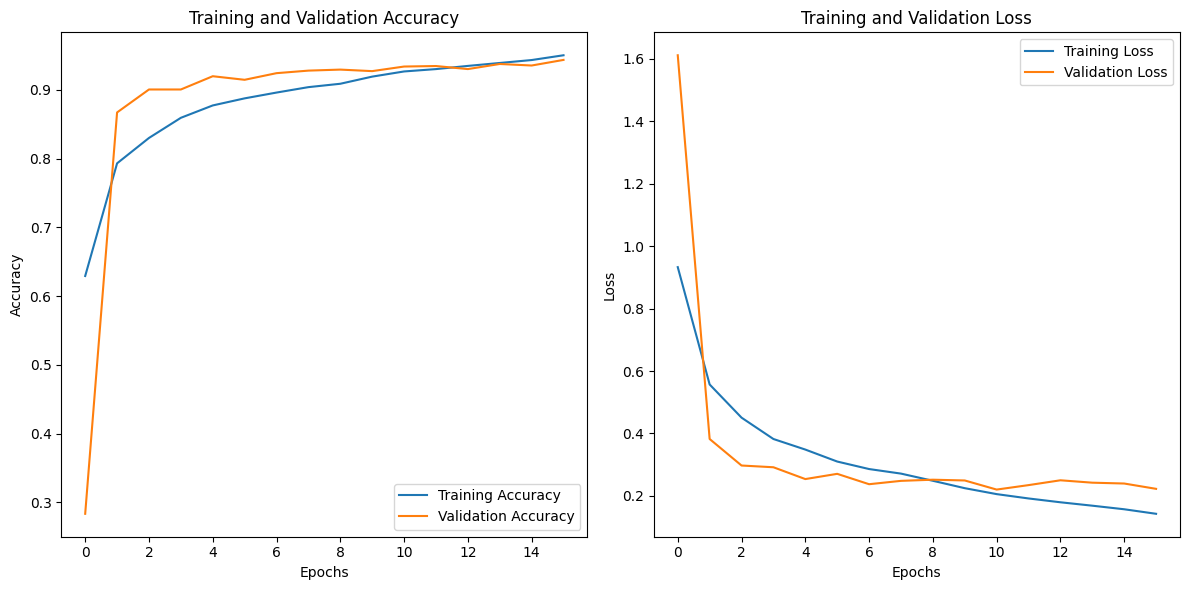

In [40]:
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.9295
F1-score (Macro Average): 0.9302
F1-score (Micro Average): 0.9295
F1-score (Weighted Average): 0.9295


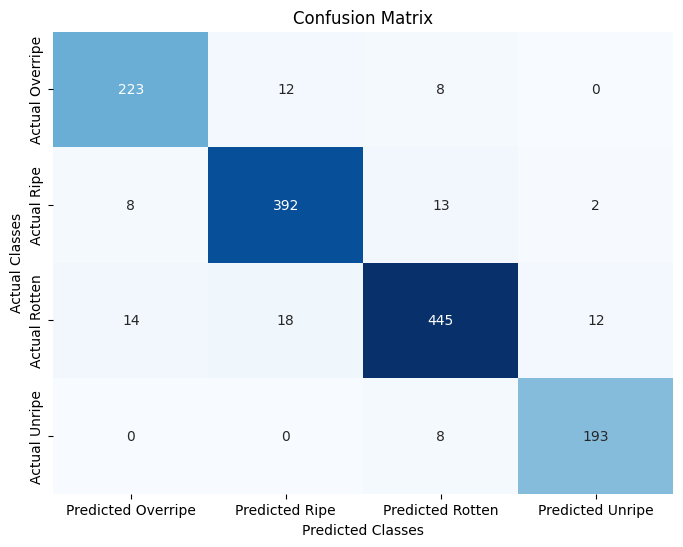


Classification Report:
              precision    recall  f1-score   support

    Overripe     0.9102    0.9177    0.9139       243
        Ripe     0.9289    0.9446    0.9367       415
      Rotten     0.9388    0.9100    0.9242       489
      Unripe     0.9324    0.9602    0.9461       201

    accuracy                         0.9295      1348
   macro avg     0.9276    0.9331    0.9302      1348
weighted avg     0.9296    0.9295    0.9295      1348



In [41]:
# Menghitung prediksi untuk data testing
preds_2 = model_2.predict(test_ds, verbose=0)

# Prediksi kelas dengan probabilitas tertinggi
predicted_classes_2 = tf.argmax(preds_2, axis=-1).numpy()

# Menghitung akurasi
accuracy_2 = accuracy_score(test_labels_idx, predicted_classes_2)
print(f"Accuracy: {accuracy_2:.4f}")

# Menghitung F1-score untuk setiap kelas dan rata-rata (macro, micro, weighted)
f1_macro_2 = f1_score(test_labels_idx, predicted_classes_2, average='macro')
f1_micro_2 = f1_score(test_labels_idx, predicted_classes_2, average='micro')
f1_weighted_2 = f1_score(test_labels_idx, predicted_classes_2, average='weighted')

print(f"F1-score (Macro Average): {f1_macro_2:.4f}")
print(f"F1-score (Micro Average): {f1_micro_2:.4f}")
print(f"F1-score (Weighted Average): {f1_weighted_2:.4f}")

# Confusion Matrix
cm_2 = confusion_matrix(test_labels_idx, predicted_classes_2, labels=[0, 1, 2, 3])
cm_df_2 = pd.DataFrame(cm_2, index=["Actual Overripe", "Actual Ripe", "Actual Rotten", "Actual Unripe"],
                     columns=["Predicted Overripe", "Predicted Ripe", "Predicted Rotten", "Predicted Unripe"])

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels_idx, predicted_classes_2, target_names=['Overripe', 'Ripe', 'Rotten', 'Unripe'], digits=4))

## **Model Exp 3 - CNN Architecture Using 128 Neurons in Conv Layer:**



In [16]:
# Clear previous model
tf.keras.backend.clear_session()

# Inisialisasi model
model_3 = Sequential()

# 1st Convolutional layer
model_3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer
model_3.add(Conv2D(128, (4, 4), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer
model_3.add(Conv2D(128, (7, 7), padding='same', activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D((2, 2)))

# Flatten & Fully Connected Layers
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(4, activation='softmax'))  # multi-class classification

# Compile model dengan Adam
model_3.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Summary
model_3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,924,036 (53.12 MB)

 Trainable params: 13,923,268 (53.11 MB)

 Non-trainable params: 768 (3.00 KB)

In [17]:
# Callback untuk menyimpan model terbaik
checkpoint_3 = ModelCheckpoint('best_model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

# Early stopping untuk menghentikan training jika tidak ada perbaikan dalam validasi loss
early_stopping_3 = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

# Training model dengan dataset
history_3 = model_3.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[checkpoint_3, early_stopping_3]
)

Epoch 1/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6397 - loss: 0.9311
Epoch 1: val_loss improved from inf to 1.47473, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 125s 311ms/step - accuracy: 0.6400 - loss: 0.9304 - val_accuracy: 0.4651 - val_loss: 1.4747
Epoch 2/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8367 - loss: 0.4402
Epoch 2: val_loss improved from 1.47473 to 0.29295, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 104s 247ms/step - accuracy: 0.8367 - loss: 0.4401 - val_accuracy: 0.9058 - val_loss: 0.2929
Epoch 3/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8703 - loss: 0.3528
Epoch 3: val_loss improved from 0.29295 to 0.26160, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 142s 246ms/step - accuracy: 0.8703 - loss: 0.3528 - val_accuracy: 0.9125 - val_loss: 0.2616
Epoch 4/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8869 - loss: 0.3085
Epoch 4: val_loss did not improve from 0.26160
337/337 ━━━━━━━━━━━━━━━━━━━━ 83s 242ms/step - accuracy: 0.8869 - loss: 0.3084 - val_accuracy: 0.9095 - val_loss: 0.2723
Epoch 5/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9042 - loss: 0.2730
Epoch 5: val_loss improved from 0.26160 to 0.23860, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 143s 247ms/step - accuracy: 0.9042 - loss: 0.2730 - val_accuracy: 0.9199 - val_loss: 0.2386
Epoch 6/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9150 - loss: 0.2302
Epoch 6: val_loss improved from 0.23860 to 0.20989, saving model to best_model.h5


337/337 ━━━━━━━━━━━━━━━━━━━━ 143s 247ms/step - accuracy: 0.9150 - loss: 0.2302 - val_accuracy: 0.9355 - val_loss: 0.2099
Epoch 7/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9245 - loss: 0.2089
Epoch 7: val_loss did not improve from 0.20989
337/337 ━━━━━━━━━━━━━━━━━━━━ 140s 242ms/step - accuracy: 0.9245 - loss: 0.2089 - val_accuracy: 0.9236 - val_loss: 0.2432
Epoch 8/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9311 - loss: 0.1901
Epoch 8: val_loss did not improve from 0.20989
337/337 ━━━━━━━━━━━━━━━━━━━━ 142s 245ms/step - accuracy: 0.9311 - loss: 0.1900 - val_accuracy: 0.9295 - val_loss: 0.2236
Epoch 9/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9422 - loss: 0.1613
Epoch 9: val_loss did not improve from 0.20989
337/337 ━━━━━━━━━━━━━━━━━━━━ 84s 245ms/step - accuracy: 0.9422 - loss: 0.1613 - val_accuracy: 0.9243 - val_loss: 0.2540
Epoch 10/50
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9506 - loss: 0.1385
Epoch 10: val_loss did 

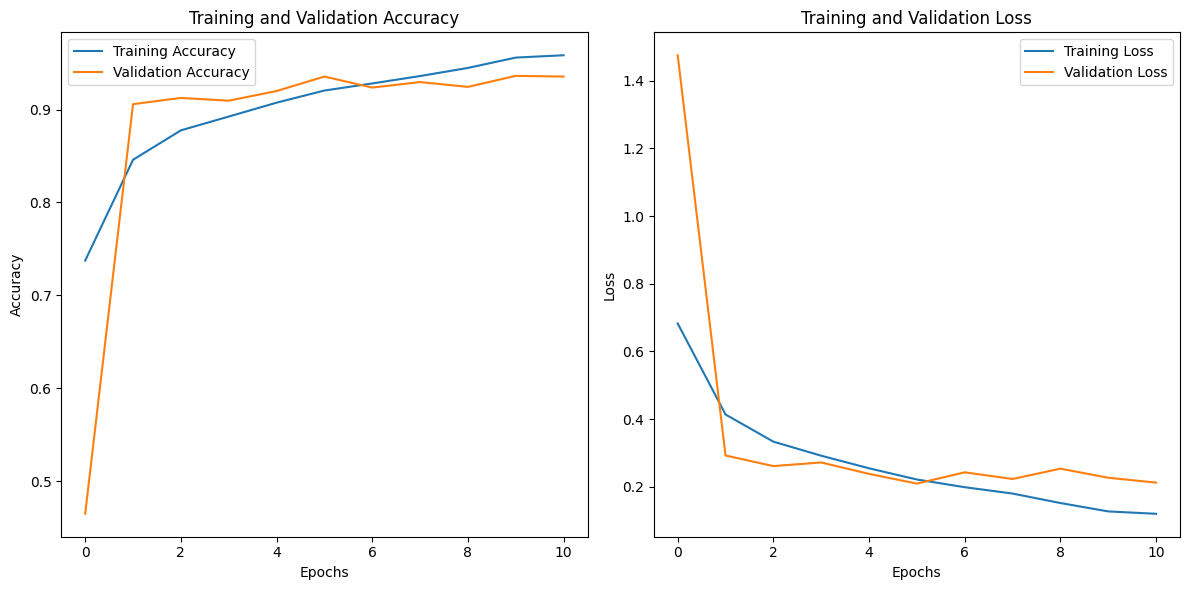

In [18]:
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.9310
F1-score (Macro Average): 0.9324
F1-score (Micro Average): 0.9310
F1-score (Weighted Average): 0.9309


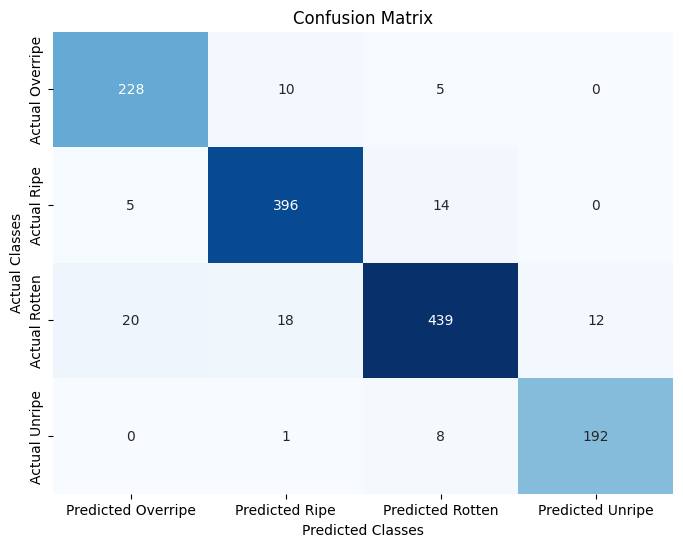


Classification Report:
              precision    recall  f1-score   support

    Overripe     0.9012    0.9383    0.9194       243
        Ripe     0.9318    0.9542    0.9429       415
      Rotten     0.9421    0.8978    0.9194       489
      Unripe     0.9412    0.9552    0.9481       201

    accuracy                         0.9310      1348
   macro avg     0.9290    0.9364    0.9324      1348
weighted avg     0.9314    0.9310    0.9309      1348



In [19]:
# Menghitung prediksi untuk data testing
preds_3 = model_3.predict(test_ds, verbose=0)

# Prediksi kelas dengan probabilitas tertinggi
predicted_classes_3 = tf.argmax(preds_3, axis=-1).numpy()

# Menghitung akurasi
accuracy_3 = accuracy_score(test_labels_idx, predicted_classes_3)
print(f"Accuracy: {accuracy_3:.4f}")

# Menghitung F1-score untuk setiap kelas dan rata-rata (macro, micro, weighted)
f1_macro_3 = f1_score(test_labels_idx, predicted_classes_3, average='macro')
f1_micro_3 = f1_score(test_labels_idx, predicted_classes_3, average='micro')
f1_weighted_3 = f1_score(test_labels_idx, predicted_classes_3, average='weighted')

print(f"F1-score (Macro Average): {f1_macro_3:.4f}")
print(f"F1-score (Micro Average): {f1_micro_3:.4f}")
print(f"F1-score (Weighted Average): {f1_weighted_3:.4f}")

# Confusion Matrix
cm_3 = confusion_matrix(test_labels_idx, predicted_classes_3, labels=[0, 1, 2, 3])
cm_df_3 = pd.DataFrame(cm_3, index=["Actual Overripe", "Actual Ripe", "Actual Rotten", "Actual Unripe"],
                     columns=["Predicted Overripe", "Predicted Ripe", "Predicted Rotten", "Predicted Unripe"])

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_3, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels_idx, predicted_classes_3, target_names=['Overripe', 'Ripe', 'Rotten', 'Unripe'], digits=4))

Berdasarkan 3 skenario pelatihan model, diperoleh model terbaik pada skenario pertama dengan akurasi pada training set sekitar 96.89% dan pada testing set sekitar 93.92%. Model dilatih menggunakan arsitektur CNN dengan 32 neuron pada layer konvolusi, optimizer AdamW, learning rate = 0.00002, dan 20 epoch.

## Menyimpan Model Terbaik ke Dalam Format SavedModel, TF-Lite dan TFJS

In [58]:
import os

# Membuat direktori untuk menyimpan model
os.makedirs("best_model", exist_ok=True)

# Simpan model dalam format SavedModel
model_1.export("best_model/banana_model")

Saved artifact at 'best_model/banana_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  133655078420752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133655061462864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657345281296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657345278224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657346455696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657345283408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657345278992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657345278032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657345284752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133657242468176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336573

In [59]:
# Membuat direktori tflite
os.makedirs("tflite", exist_ok=True)

# Konversi model SavedModel ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("best_model/banana_model")
tflite_model = converter.convert()

# Simpan model TFLite ke dalam folder tflite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt
label_map = ['overripe', 'ripe', 'rotten', 'unripe']

with open("tflite/label.txt", "w") as f:
    for label in label_map:
        f.write(label + "\n")

print("✅ Model TFLite dan label.txt berhasil disimpan di folder 'tflite/'")

✅ Model TFLite dan label.txt berhasil disimpan di folder 'tflite/'


In [60]:
# Install TensorFlow.js converter
!pip install tensorflowjs

In [63]:
# Konversi dari SavedModel ke TFJS
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  best_model/banana_model tfjs_model

2025-04-23 20:10:05.016824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745439005.039380   45483 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745439005.046454   45483 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-23 20:10:09.138155: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745439009.138315   45483 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [64]:
# Zip folder hasil konversi
!zip -r tfjs_model.zip tfjs_model

# Download zip
from google.colab import files
files.download("tfjs_model.zip")

updating: tfjs_model/ (stored 0%)
updating: tfjs_model/group1-shard3of4.bin (deflated 8%)
updating: tfjs_model/group1-shard1of4.bin (deflated 8%)
updating: tfjs_model/model.json (deflated 91%)
updating: tfjs_model/group1-shard2of4.bin (deflated 8%)
updating: tfjs_model/group1-shard4of4.bin (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference pada Data Baru

In [68]:
# Parameter
IMG_SIZE = 224
LABELS = ['overripe', 'ripe', 'rotten', 'unripe']

# Load Model
model = tf.saved_model.load("best_model/banana_model")

# Upload Gambar Pisang
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Mengambil nama file yang diupload

# Preprocess Gambar
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image.astype(np.float32)  # Pastikan tipe data adalah float32

# Fungsi untuk Inference
def predict_image(image_path):
    image = load_and_preprocess_image(image_path)

    # Menggunakan inference signature untuk prediksi
    infer = model.signatures["serving_default"]

    predictions = infer(tf.convert_to_tensor(image))["output_0"]  # Output layer
    predicted_class = LABELS[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

# Melakukan Prediksi
predicted_class, confidence = predict_image(file_name)
print(f"✅ Prediksi: {predicted_class} ({confidence*100:.2f}% confidence)")

Saving rotten_banana.jpeg to rotten_banana (2).jpeg
✅ Prediksi: rotten (100.00% confidence)
